# Multi-Agent Workflow Demo

This notebook demonstrates how to load the LangGraph `app`, visualize the graph, and run the workflow with real-time progress updates.

## 1. Environment Setup

In [1]:
import os
import sys
from pathlib import Path
from IPython.display import Image, display

from bsm_multi_agents.graph.agent_graph import app, get_graph_image
from bsm_multi_agents.graph.state import WorkflowState

cwd = Path.cwd()
project_path = cwd.parent.parent
project_path

PosixPath('/Users/yifanli/Github/model_doc_automation/TooTwo_mcp')

## 2. Visualize Workflow

We can see the internal structure of our multi-agent system.

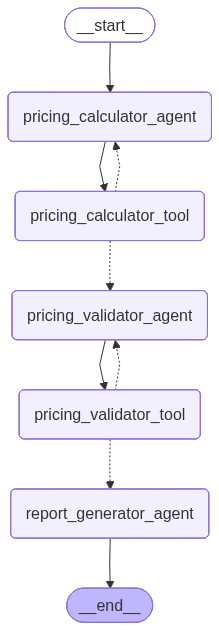

In [2]:
display(Image(get_graph_image()))

## 3. Run Workflow with Progress Streaming

We use `app.stream()` to iterate through the execution steps. The nodes will print their status directly to the output.

In [3]:
# Initial State Setup
csv_file_path = str(project_path / "data/input/dummy_options.csv")
output_dir = str(project_path / "data/cache")
server_path = str(project_path / "src/bsm_multi_agents/mcp/server.py")
local_tool_paths = [os.path.join(
    project_path, "src/bsm_multi_agents/tools/my_add.py"
)]
final_report_path = str(project_path / "data/cache/final_report.docx")

initial_state = WorkflowState(
    csv_file_path=csv_file_path,
    output_dir=output_dir,
    server_path=server_path,
    local_tool_paths=local_tool_paths,
    final_report_path=final_report_path,
    errors=[],
    messages=[],
    # "remaining_steps": 10,
)

config = {"configurable": {"thread_id": "demo_thread_1"}}

print("Starting Multi-Agent Workflow...\n")

# final_state = app.invoke(
#     init_state,
#     config={"configurable": {"thread_id": "run-1"}}
# )
for event in app.stream(initial_state, config=config, stream_mode="values"):
    # Each 'event' corresponds to a state update after a node execution
    # The 'print' statements inside nodes will appear here in real-time
    pass

print("\nWorkflow Complete.")

Starting Multi-Agent Workflow...


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Tool] Executing tool calls...

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Tool] Executing validation calls...

>>> [Report Generator Agent] Compiling final report...

Workflow Complete.


## 4. Check Results

In [5]:
final_state = app.get_state(config).values
if final_state.get("errors"):
    print("Errors:", final_state["errors"])
else:
    print("Final Report Path:", final_state.get("final_report_path"))
    if os.path.exists(final_state.get("final_report_path", "")):
        print("File successfully generated!")

Final Report Path: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/final_report.docx
File successfully generated!
